#Discretizations
Here we show how different discretizations work within MasterMSM. An important note is that not all discretizations will be sensible for all systems, but as usual the alanine dipeptide is a good testbed.

In [1]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

We start by importing the trajectory.

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


###Core Ramachandran angle regions
Following previous work we can use core regions in the Ramachandran map to define our states. We use utilities from MDtraj to compute the Phi and Psi dihedrals.

In [3]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

Then we run the actual discretization, using only two states for the alpha and extended conformations.

In [4]:
tr.discretize(states=['A', 'E'])
tr.find_keys()

Finally we obtain the MSM

In [5]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB.do_msm(i)
    msm_alaTB.msms[i].do_trans()
    msm_alaTB.msms[i].boots(plot=False)


 Building MSM from 
[['data/protein_only.xtc']]
     # states: 2


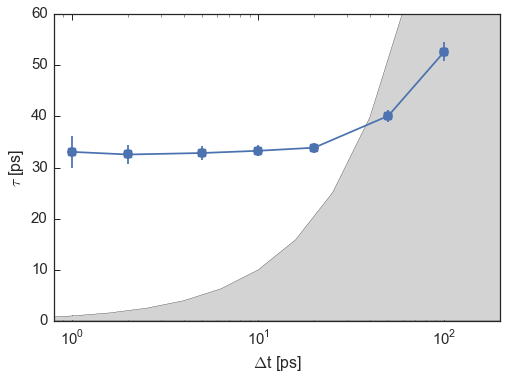

In [6]:
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[0],msm_alaTB.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,60)
_ = ax.set_xscale('log')
#ax.set_yscale('log')

##Fine grid on the Ramachandran map
Alternatively we can make a grid on the Ramachandran map with many more states.

In [48]:
tr.discretize(method="ramagrid", nbins=20)
tr.find_keys()

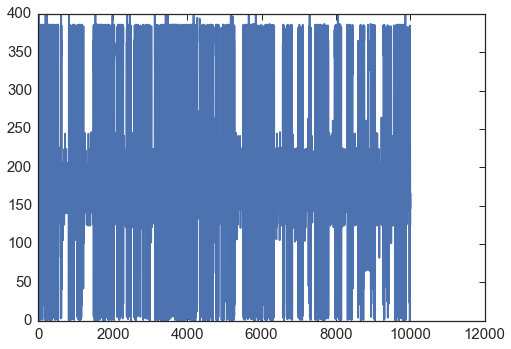

In [49]:
plt.plot([x for x in tr.distraj])

In [50]:
from mastermsm.msm import msm
msm_alaTB_grid = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB_grid.do_msm(i, sym=False)
    msm_alaTB_grid.msms[i].do_trans()
    msm_alaTB_grid.msms[i].boots(plot=False)


 Building MSM from 
[['data/protein_only.xtc']]
     # states: 197


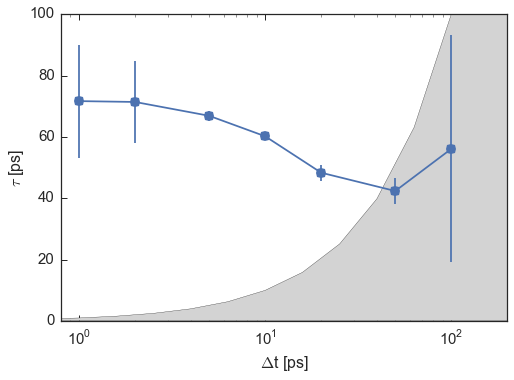

In [52]:
tau_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[0],msm_alaTB_grid.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB_grid.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,100)
_ = ax.set_xscale('log')
#ax.set_yscale('log')

Which eigenvectors does this correspond to?

In [55]:
msm_alaTB_grid.msms[10].do_trans(evecs=True)

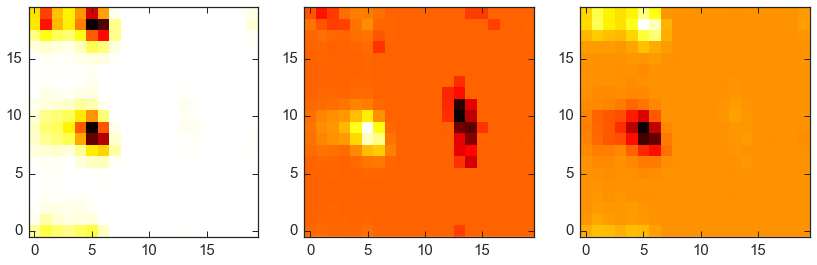

In [66]:
fig, ax = plt.subplots(1,3, figsize=(14,5))
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, msm_alaTB_grid.msms[10].rvecsT[:,0])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = i[1]
ax[0].imshow(mat.transpose(), interpolation="none", origin='lower', cmap='hot')
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, msm_alaTB_grid.msms[10].rvecsT[:,1])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = -i[1]
ax[1].imshow(mat.transpose(), interpolation="none", origin='lower', cmap='hot')
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, msm_alaTB_grid.msms[10].rvecsT[:,2])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = -i[1]
_ = ax[2].imshow(mat.transpose(), interpolation="none", origin='lower', cmap='hot')


### 